In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
import seaborn as sns
sns.set()
import torch 
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
from torch.distributions import Categorical
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.signal import argrelmax
from tqdm import tqdm_notebook as tqdm
import scipy
import numpy as np
import os

# Define and run the mixture density network

### signal dataset

In [3]:
cd /Users/james/signal

/Users/james/signal


In [4]:
from utils import prepare_dataset, preprocess,preprocess_zscore, get_original_parameters, report_metrics, mdn_logp, mdn_loss
from model import MixtureDensityNetwork, IsotropicGaussianMixture

In [5]:
X_train, X_test, y_train, y_test = prepare_dataset(featurename='data_6')
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (750, 24)
Size of output in training data: (750, 2)
Size of features in test data: (250, 24)
Size of output in test data: (250, 2)


In [85]:
class MixtureDensityNetwork(nn.Module):
    '''Create a mixture density network
        Args:
        n_input: number of input dimensions
        n_hiddens: an integer or a list. Sizes of hidden layers.
        n_output: number of output dimensions
        n_components: number of Gaussian distributions
        logsigma_min, logsigma_max: range to clip log sigma to
        '''
    def __init__(self, n_input = 24, n_hiddens = 10, n_output = 6,
                 n_components=4,
                 logsigma_min=-3, logsigma_max=3):
        super(MixtureDensityNetwork, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_components = n_components
        self.n_hiddens = np.atleast_1d(n_hiddens)
        self.logsigma_min = logsigma_min
        self.logsigma_max = logsigma_max

        layers = []
        n_hidden_prev = n_input
        for n in self.n_hiddens:
            layers.append(nn.Linear(n_hidden_prev, n))
            layers.append(nn.ReLU())
            n_hidden_prev = n
        layers.append(nn.Linear(n_hidden_prev, n_components*(2*n_output + 1)))
        self.encoder = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.encoder(x)
        logsigma = torch.clamp(0.5*x[:, :self.n_components*self.n_output],
                               self.logsigma_min,
                               self.logsigma_max)
        logsigma = logsigma.view(-1, self.n_components, self.n_output)
        mu = x[:, (self.n_components*self.n_output):(self.n_components*self.n_output*2)]
        mu = mu.view(-1, self.n_components, self.n_output)
        pi = self.softmax(x[:, (self.n_components*self.n_output*2):])
        xpi = pi+ 1e-3
        ypi= xpi/xpi.sum(dim=-1, keepdim=True)
        logpi = torch.log(ypi)
        logpi = logpi.view(-1, self.n_components)
        return logpi, logsigma, mu

In [201]:
n_components= 20
model = MixtureDensityNetwork(n_input=24, n_output=2,  n_components = n_components,n_hiddens=[22, 20, 18],
                             logsigma_min=-2, logsigma_max=1)
optimizer = optim.Adam(model.parameters())
model

MixtureDensityNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=24, out_features=22, bias=True)
    (1): ReLU()
    (2): Linear(in_features=22, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=18, bias=True)
    (5): ReLU()
    (6): Linear(in_features=18, out_features=100, bias=True)
  )
  (softmax): Softmax()
)

In [189]:
X_train.shape,y_train.shape

((750, 24), (750, 2))

## scale data to deal with loss exploding problem

In [190]:
# create data loaders
scalers = {}
datas = [X_train, X_test, y_train, y_test]
for i in range(4):
    datas[i],scalers[i]  = preprocess_zscore(datas[i])
X_train_, X_test_, y_train_, y_test_ = datas
batch_size = 10
train_ = utilsdata.TensorDataset(torch.from_numpy(X_train_.astype('float32')),
                                torch.from_numpy(y_train_.astype('float32')))
test_ = utilsdata.TensorDataset(torch.from_numpy(X_test_.astype('float32')),
                               torch.from_numpy(y_test_.astype('float32')))
train_loader_ = torch.utils.data.DataLoader(
                 dataset=train_,
                 batch_size=batch_size,
                 shuffle=True)
test_loader_ = torch.utils.data.DataLoader(
                dataset=test_,
                batch_size=batch_size,
                shuffle=False)

print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape)

('X_train.shape =', (750, 24), 'X_test.shape =', (250, 24))


In [191]:
trainlosses, testlosses = {},{}
for epoch in tqdm(range(2000)):
    train_loss = []
    for i_batch, batch_data in enumerate(train_loader_):
        x, y = batch_data
        model.zero_grad()
        logpi, logsigma, mu = model(x) 
        loss = mdn_loss(y, logpi, logsigma, mu)
        loss.backward()
        optimizer.step() 
        train_loss.append(loss.item()*x.size()[0])
    train_loss = np.sum(train_loss)/len(train_loader_.dataset)
    
    test_loss = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(test_loader_):
            x, y = batch_data
            logpi, logsigma, mu = model(x) 
            loss = mdn_loss(y, logpi, logsigma, mu)
            test_loss.append(loss.item()*x.size()[0])
        test_loss = np.sum(test_loss)/len(test_loader_.dataset)
    
    if epoch%10 == 0:
        print('[Epoch {:d}] train loss: {}, test loss: {}'.format(epoch, train_loss, test_loss))
    trainlosses[epoch] = train_loss
    testlosses[epoch] = test_loss
dir_name = time.strftime("%Y-%m-%d") + '_' + time.strftime("%H-%M-%S")
path_model = os.path.join('models/', dir_name)
if not os.path.exists(path_model):
    os.makedirs(path_model)
torch.save(model.state_dict(), path_model+'model')

HBox(children=(IntProgress(value=0, max=2000), HTML(value=u'')))

[Epoch 0] train loss: 1.3635980765, test loss: 1.18536683083
[Epoch 10] train loss: -0.828147383928, test loss: -0.732955250144
[Epoch 20] train loss: -0.944970548153, test loss: -0.848822315931
[Epoch 30] train loss: -0.984236541589, test loss: -0.867240434289
[Epoch 40] train loss: -1.00764444749, test loss: -0.858400526047
[Epoch 50] train loss: -1.01301159064, test loss: -0.811643688977
[Epoch 60] train loss: -1.0171383063, test loss: -0.863449126482
[Epoch 70] train loss: -1.03146681388, test loss: -0.861569274962
[Epoch 80] train loss: -1.03167099396, test loss: -0.874450853169
[Epoch 90] train loss: -1.03366854429, test loss: -0.890577912331
[Epoch 100] train loss: -1.03549397628, test loss: -0.898803068399
[Epoch 110] train loss: -1.04590262334, test loss: -0.860868190527
[Epoch 120] train loss: -1.03535627445, test loss: -0.870642186403
[Epoch 130] train loss: -1.04509784857, test loss: -0.895577815175
[Epoch 140] train loss: -1.0448951141, test loss: -0.885118480921
[Epoch 15

[Epoch 1230] train loss: -1.07509644349, test loss: -0.938757545948
[Epoch 1240] train loss: -1.0745112896, test loss: -0.939341843128
[Epoch 1250] train loss: -1.07018386682, test loss: -0.935255906582
[Epoch 1260] train loss: -1.07399158796, test loss: -0.925472295284
[Epoch 1270] train loss: -1.07354049842, test loss: -0.931556191444
[Epoch 1280] train loss: -1.0738090388, test loss: -0.934351024628
[Epoch 1290] train loss: -1.07400551955, test loss: -0.929279384613
[Epoch 1300] train loss: -1.07046504815, test loss: -0.934977607727
[Epoch 1310] train loss: -1.07150674025, test loss: -0.936224470139
[Epoch 1320] train loss: -1.07389588197, test loss: -0.92999478817
[Epoch 1330] train loss: -1.07298113982, test loss: -0.93725466013
[Epoch 1340] train loss: -1.06735734463, test loss: -0.927524797916
[Epoch 1350] train loss: -1.07280342579, test loss: -0.927120778561
[Epoch 1360] train loss: -1.06895609697, test loss: -0.94038693428
[Epoch 1370] train loss: -1.07595441182, test loss: -

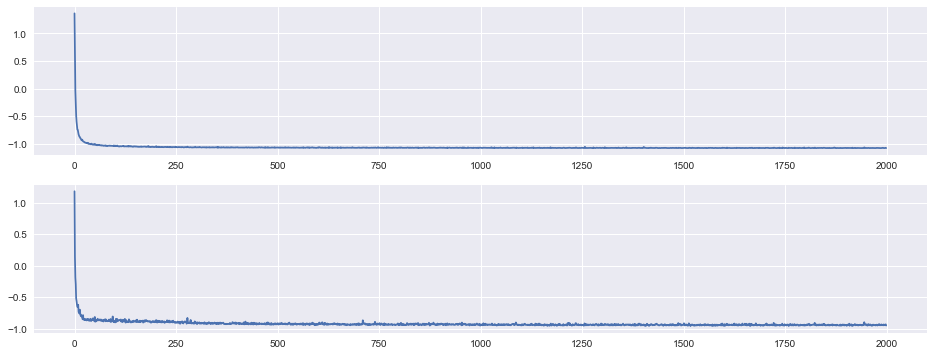

In [192]:
fig,ax=plt.subplots(2,1,figsize=(16,6))
ax[0].plot(np.array([trainlosses[i] for i in range(len(trainlosses))]))
ax[1].plot(np.array([testlosses[i] for i in range(len(testlosses))]))

In [193]:
logpi_pred, logsigma_pred, mu_pred = model(torch.Tensor(X_test_))
logpi_pred.size(), logsigma_pred.size(), mu_pred.size()
pi_reversed, sigma_reversed, mu_reversed = get_original_parameters(logpi_pred, logsigma_pred, mu_pred)
pi_reversed.shape, sigma_reversed.shape, mu_reversed.shape

((250, 20), (250, 20, 2), (250, 20, 2))

In [194]:
def get_prediction(pi,mu,sigma,n_components):
    model = IsotropicGaussianMixture(n_components, n_dim=2)
    model.set_params(pi,mu,sigma)
    modes = model.find_modes(n_init=10)
    p_modes = model.pdf(modes)
    #print p_modes,modes
    index=np.where(p_modes==np.max(p_modes))
    return p_modes[index[0]], modes[index[0]]

In [195]:
ind = 10
get_prediction(pi_reversed[ind], mu_reversed[ind],sigma_reversed[ind],n_components)

(array([8.68956237]), array([[-0.82187599,  0.25157949]]))

In [204]:
def plot_result(ax,ind,n_components=20):
    gaussianmodel = IsotropicGaussianMixture(n_components, n_dim=2)
    gaussianmodel.set_params(pi_reversed[ind],  mu_reversed[ind], sigma_reversed[ind])
    X_grid, Y_grid = np.mgrid[-2:2:0.02, -2:2:0.02]
    X = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    modes = gaussianmodel.find_modes(n_init=10)
    #print ('modes',modes)
    print ('p_modes',gaussianmodel.pdf(modes))
    ax.contour(X_grid, Y_grid, gaussianmodel.pdf(X).reshape(X_grid.shape), 
                   linewidths=0.5, levels=np.linspace(0, 1, 80))
    ax.set_title('sample '+str(ind))

In [205]:
mu_reversed.shape

(250, 20, 2)

In [206]:
np.array([mu_reversed[i] for i in range(250)])

array([[[-0.15059021, -0.783522  ],
        [-0.15187606, -0.78607357],
        [-0.15202492, -0.78461164],
        ...,
        [-0.15116556, -0.78482705],
        [-0.15183666, -0.783879  ],
        [-0.15048389, -0.78455484]],

       [[-0.68380183,  0.67557776],
        [-0.68408126,  0.6722326 ],
        [-0.68421483,  0.674314  ],
        ...,
        [-0.683856  ,  0.6740893 ],
        [-0.68472415,  0.67439175],
        [-0.6831613 ,  0.6741034 ]],

       [[ 1.4772437 ,  0.03877265],
        [ 1.478065  ,  0.03534095],
        [ 1.4764409 ,  0.03703204],
        ...,
        [ 1.4780953 ,  0.03770766],
        [ 1.4753678 ,  0.0375062 ],
        [ 1.4772843 ,  0.03732933]],

       ...,

       [[-0.8617359 , -0.32033554],
        [-0.8632931 , -0.3233916 ],
        [-0.8629817 , -0.32148513],
        ...,
        [-0.862567  , -0.32195032],
        [-0.86273944, -0.3210724 ],
        [-0.86138934, -0.32159698]],

       [[ 1.4855865 , -1.2472684 ],
        [ 1.4847795 , -1.25

In [207]:
np.array([sigma_reversed[i] for i in range(250)]).reshape(-1,2).shape

(5000, 2)

([array([4.996e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00]),
  array([4.994e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
         0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.0

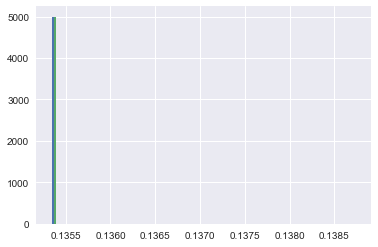

In [208]:
hist(np.array([sigma_reversed[i] for i in range(250)]).reshape(-1,2),bins=50)

('p_modes', array([8.68956237]))
('p_modes', array([1.59729185e-32, 8.68956470e+00]))
('p_modes', array([8.14569933e-35]))
('p_modes', array([8.68956392e+00, 2.87235016e-39]))
('p_modes', array([8.68956450e+00, 2.89858889e-16]))
('p_modes', array([5.66245427e-11, 8.68956400e+00]))
('p_modes', array([8.68956431e+00, 6.44926952e-36]))
('p_modes', array([4.77113981e-13, 8.68956289e+00]))
('p_modes', array([8.68956278e+00, 4.69789815e-19]))
('p_modes', array([8.68956407e+00, 3.38783509e-20]))
('p_modes', array([8.59965607e-34, 8.68956484e+00]))
('p_modes', array([8.68956741]))
('p_modes', array([1.26430494e-18]))
('p_modes', array([8.6895645]))
('p_modes', array([8.68956439e+00, 3.83227886e-42]))
('p_modes', array([1.86953892e-26, 8.68956453e+00]))


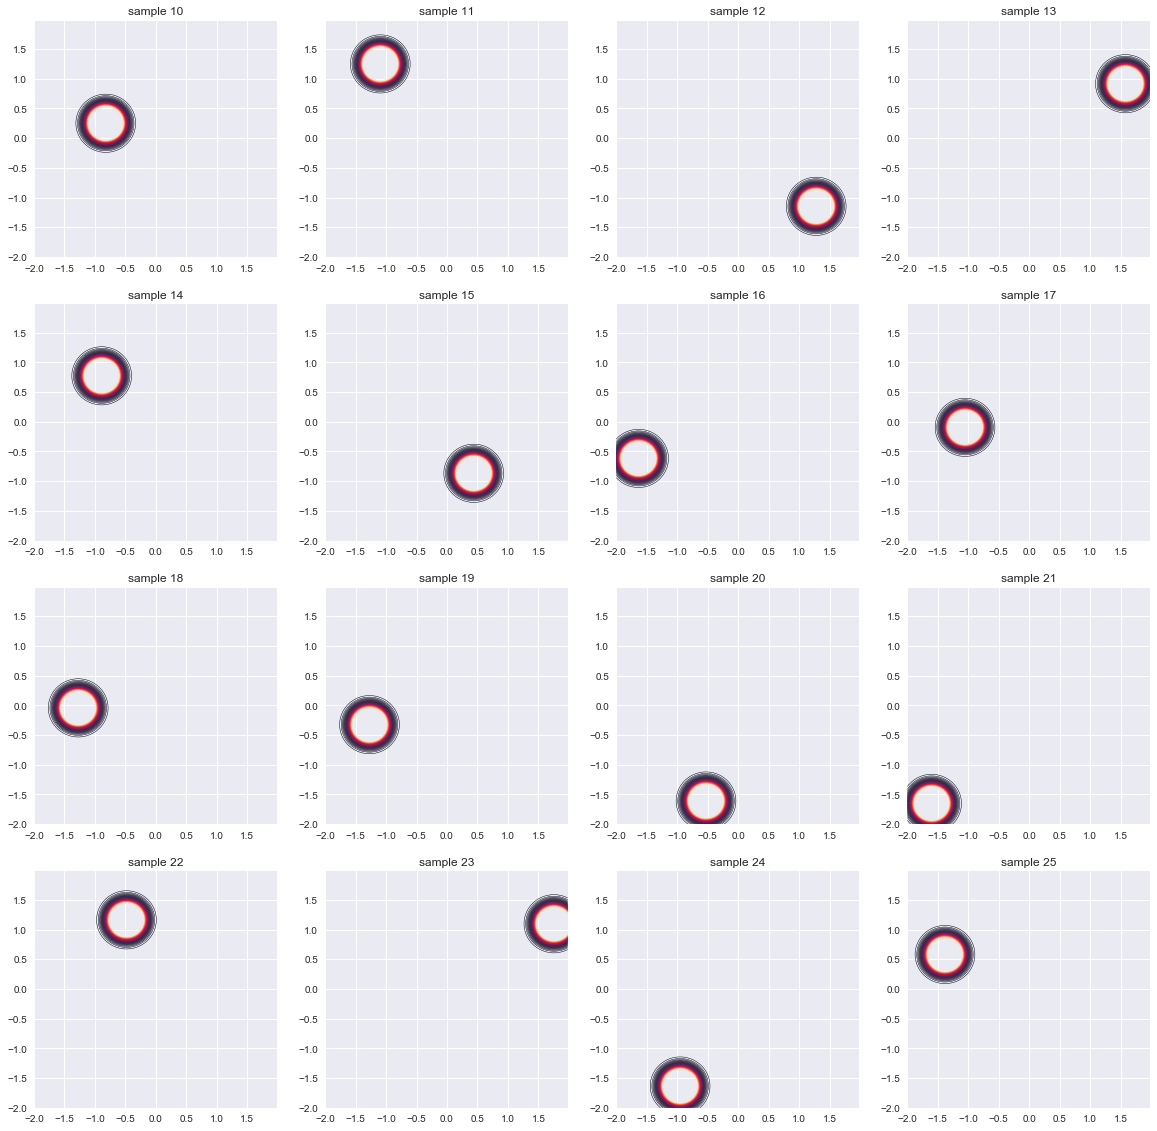

In [209]:
fig,ax=plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        plot_result(ax[i,j],10+i*4+j)

In [210]:
prediction_xy = np.ndarray([250,2])
probabes = np.ndarray([250])
for i in tqdm(range(250)):
    probabes[i], prediction_xy[i] = get_prediction(pi_reversed[i], mu_reversed[i],sigma_reversed[i],n_components)
prediction_xy_reverse = scalers[3].inverse_transform(prediction_xy)

HBox(children=(IntProgress(value=0, max=250), HTML(value=u'')))

In [211]:
def plot_arrow(y_testdata,y_test):
    fig,ax=plt.subplots(1,figsize=(9,9))
    c = np.sum(y_testdata**2+y_test**2,axis=1)
    ax.scatter(y_testdata[:,0],y_testdata[:,1], s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
    ax.scatter(y_test[:,0],y_test[:,1], s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  
        np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    xorigin = y_testdata[:,0].ravel()
    yorigin = y_testdata[:,1].ravel()
    dx = y_test[:,0].ravel()-y_testdata[:,0].ravel()
    dy = y_test[:,1].ravel()-y_testdata[:,1].ravel()
    print (xorigin.shape, yorigin.shape, dx.shape, dy.shape)
    ax.arrow(xorigin[2], yorigin[2], dx[2], dy[2], color = 'b')
    for i in range(y_testdata.shape[0]):
        ax.arrow(y_testdata[i,0],y_testdata[i,1],
            y_test[i,0]-y_testdata[i,0],y_test[i,1]-y_testdata[i,1],color = 'b')
#for i in range(y_testdata.shape[0]):
#    ax.arrow(y_testdata[i,0],y_testdata[i,1],
#            y_test[i,0]-y_testdata[i,0],y_test[i,1]-y_testdata[i,1],color = 'b')

In [212]:
report_metrics(prediction_xy_reverse,y_test)

(648.1755656985864, (0.9186420899473, 5.557053585959897e-203))

In [213]:
y_test.shape

(250, 2)

((250,), (250,), (250,), (250,))


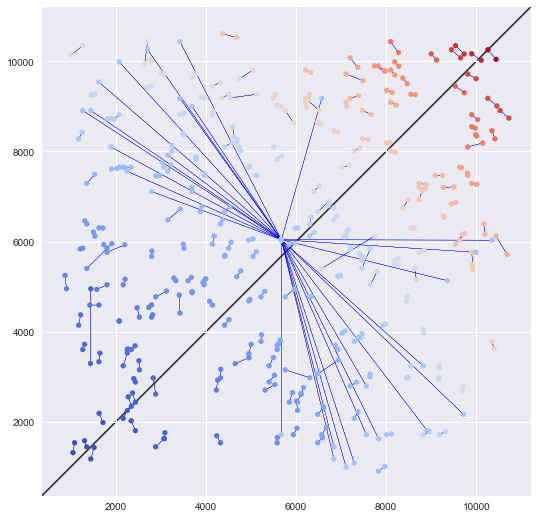

In [214]:
plot_arrow(prediction_xy_reverse,y_test)

(array([ 27.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 223.]),
 array([5.33252624e-51, 8.68956760e-01, 1.73791352e+00, 2.60687028e+00,
        3.47582704e+00, 4.34478380e+00, 5.21374056e+00, 6.08269732e+00,
        6.95165408e+00, 7.82061084e+00, 8.68956760e+00]),
 <a list of 10 Patch objects>)

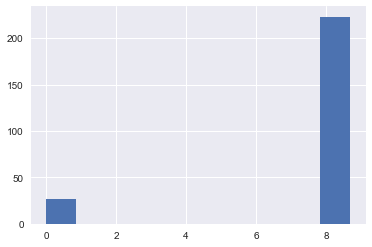

In [215]:
hist(probabes)

### 后续思路
- 改成zscore
- pi加限制，加pseudocount 基本解决nan问题
- loss下降与结果好相关不强，极值点的pdf过小，总体太平均了
- 研究各个参数
- 考虑研究数据本身的特征
- probablity 过小
- 大规模测试参数： RMSE作为衡量指标
    - 用哪些数据集
    - sigma 范围
    - Gaussian数量
    - MLP网络相关参数
        - layer
        - activation...
- 观察参数和结果的规律
- outlier：距离差大的是不是不确定度也大
    - 看看误差大的样本是不是不确定度也大，如果真的相关性强的话，那我们就找到了一个很好的方法来衡量样本的预测难度
- 借鉴bishop的一些绘图思路，可视化出来probablity
- 生成二维分布时是否可以考虑$\rho$
- 其他

In [216]:
import pickle, h5py, time, argparse, itertools, datetime
import torch 
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
from torch.distributions import Categorical
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.signal import argrelmax
from tqdm import tqdm_notebook as tqdm
import scipy
import numpy as np
import os

In [226]:
data_name = 'data_6'
n_components =6
batchsize =10
earlystopping_epoch_nums=20
nhidden1=22
nhidden2=20
nhidden3=18
logsigma_min = -2
logsigma_max =1

In [218]:
from utils import prepare_dataset, preprocess,preprocess_zscore, get_original_parameters, report_metrics, mdn_logp, mdn_loss
from model import MixtureDensityNetwork, IsotropicGaussianMixture

In [220]:
X_train, X_test, y_train, y_test = prepare_dataset(featurename=data_name)

In [221]:
model = MixtureDensityNetwork(n_input=24, n_output=2,  n_components = n_components,
                              n_hiddens=[nhidden1, nhidden2, nhidden3],
                             logsigma_min=logsigma_min, logsigma_max=logsigma_max )
optimizer = optim.Adam(model.parameters())

In [223]:
# create data loaders
scalers = {}
datas = [X_train, X_test, y_train, y_test]
for i in range(4):
    datas[i],scalers[i]  = preprocess_zscore(datas[i])
X_train_, X_test_, y_train_, y_test_ = datas
batch_size = batchsize
train_ = utilsdata.TensorDataset(torch.from_numpy(X_train_.astype('float32')),
                                torch.from_numpy(y_train_.astype('float32')))
test_ = utilsdata.TensorDataset(torch.from_numpy(X_test_.astype('float32')),
                               torch.from_numpy(y_test_.astype('float32')))
train_loader_ = torch.utils.data.DataLoader(
                 dataset=train_,
                 batch_size=batch_size,
                 shuffle=True)
test_loader_ = torch.utils.data.DataLoader(
                dataset=test_,
                batch_size=batch_size,
                shuffle=False)

print('X_train.shape =', X_train.shape, 'X_test.shape =', X_test.shape,
     'y_train.shape =', y_train.shape, 'y_test.shape =', y_test.shape)

('X_train.shape =', (750, 24), 'X_test.shape =', (250, 24), 'y_train.shape =', (750, 2), 'y_test.shape =', (250, 2))


In [231]:
trainlosses, testlosses = {},{}
for epoch in tqdm(range(2000)):
    train_loss = []
    for i_batch, batch_data in enumerate(train_loader_):
        x, y = batch_data
        model.zero_grad()
        logpi, logsigma, mu = model(x) 
        loss = mdn_loss(y, logpi, logsigma, mu)
        loss.backward()
        optimizer.step() 
        train_loss.append(loss.item()*x.size()[0])
    train_loss = np.sum(train_loss)/len(train_loader_.dataset)
    
    test_loss = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(test_loader_):
            x, y = batch_data
            logpi, logsigma, mu = model(x) 
            loss = mdn_loss(y, logpi, logsigma, mu)
            test_loss.append(loss.item()*x.size()[0])
        test_loss = np.sum(test_loss)/len(test_loader_.dataset)
    
    if epoch%10 == 0:
        print('[Epoch {:d}] train loss: {}, test loss: {}'.format(epoch, train_loss, test_loss))
    ###### early stop to avoid unnecessary training######
    if epoch >=200:
        if epoch%10 == 0:
            recentlossmin = np.min(np.array([testlosses[i] for i in np.arange(epoch-earlystopping_epoch_nums,epoch)]))
            otherlossmin = np.min(np.array([testlosses[i] for i in np.arange(0,epoch-earlystopping_epoch_nums)]))
            print (recentlossmin,otherlossmin)
            if recentlossmin > otherlossmin: # no longer decrease
                print ('exist at epoch:' +str(epoch))
                break
    trainlosses[epoch] = train_loss
    testlosses[epoch] = test_loss
dir_name = ('batch_'+str(batchsize)+'_gaussian_'+str(n_components)+
            '_datatype_'+data_name+'_batch_'+str(batchsize)+'_earlyepoch_'+str(earlystopping_epoch_nums))
print dir_name
path_model = os.path.join('models/', dir_name)
if not os.path.exists(path_model):
    os.makedirs(path_model)
torch.save(model.state_dict(), path_model+'/model')

HBox(children=(IntProgress(value=0, max=2000), HTML(value=u'')))

[Epoch 0] train loss: -1.06831654867, test loss: -0.916253258586
[Epoch 10] train loss: -1.06803993225, test loss: -0.934752194881
[Epoch 20] train loss: -1.07181910038, test loss: -0.929882294536
[Epoch 30] train loss: -1.06770717144, test loss: -0.925072163343
[Epoch 40] train loss: -1.07076227029, test loss: -0.930380038619
[Epoch 50] train loss: -1.06755313873, test loss: -0.929969555736
[Epoch 60] train loss: -1.07238934517, test loss: -0.927740150392
[Epoch 70] train loss: -1.06951699893, test loss: -0.928523500189
[Epoch 80] train loss: -1.0708927695, test loss: -0.94979927659
[Epoch 90] train loss: -1.07273093224, test loss: -0.936233529449
[Epoch 100] train loss: -1.06997886817, test loss: -0.926201520562
[Epoch 110] train loss: -1.06819523017, test loss: -0.931423989534
[Epoch 120] train loss: -1.06733302752, test loss: -0.922227134407
[Epoch 130] train loss: -1.07295165539, test loss: -0.92124573946
[Epoch 140] train loss: -1.06670186838, test loss: -0.922308366895
[Epoch 15

In [232]:
logpi_pred, logsigma_pred, mu_pred = model(torch.Tensor(X_test_))
pi_reversed, sigma_reversed, mu_reversed = get_original_parameters(logpi_pred, logsigma_pred, mu_pred)

In [233]:
def get_prediction(pi,mu,sigma,n_components):
    model = IsotropicGaussianMixture(n_components, n_dim=2)
    model.set_params(pi,mu,sigma)
    modes = model.find_modes(n_init=10)
    p_modes = model.pdf(modes)
    #print p_modes,modes
    index=np.where(p_modes==np.max(p_modes))
    return p_modes[index[0]], modes[index[0]]

In [234]:
prediction_xy = np.ndarray([250,2])
probabes = np.ndarray([250])
for i in tqdm(range(250)):
    probabes[i], prediction_xy[i] = get_prediction(pi_reversed[i], mu_reversed[i],sigma_reversed[i],n_components)
prediction_xy_reverse = scalers[3].inverse_transform(prediction_xy)

HBox(children=(IntProgress(value=0, max=250), HTML(value=u'')))

In [235]:
parametersinfo = np.array([data_name,str(n_components),str(batchsize),str(earlystopping_epoch_nums),
str(nhidden1),str(nhidden2),str(nhidden3),str(logsigma_min),str(logsigma_max)])

In [242]:
np.savetxt(path_model+'/rmse.txt',np.array([report_metrics(prediction_xy_reverse,y_test)[0]]))
np.savetxt(path_model+'/pcc.txt',np.array([report_metrics(prediction_xy_reverse,y_test)[1][0]]))
np.savetxt(path_model+'/probabse.txt',probabes)
np.savetxt(path_model+'/parameters.txt',parametersinfo,fmt="%s")

- data whole rss aoa toa data_4 data_5 data_6
- n_components 2-20
- batch 5-30 5
- early_epoch 10 100
- nhidden1 20-30
- nhidden2 15-25
- nhidden3 10-20
- logsigmamin -10 -1
- logsigmamax 1 5

python test_parameters.py --data whole --n_components 10 --batch 20 --early_epoch 20 --nhidden1 20 --nhidden2 18 --nhidden3 16 --logsigmamin 2 --logsigmamax 2

python test_parameters.py --data whole --n_components 10 --batch 20 --early_epoch 20 --nhidden1 20 --nhidden2 18 --nhidden3 16 --logsigmamin 2 --logsigmamax 2

In [ ]:
7 9 7 5 5 5 5

In [1]:
453600 *90 /3600/24

472

In [ ]:
{
COUNTER=0
for dataname in whole rss aoa toa data_4 data_5 data_6
do
    for n_components in $(seq 2 4 20)
    do
        for batch in $(seq 5 5 20)
        do
            for early_epoch in $(seq 20 20 100)
            do
                for logsigmamin in $(seq -4 -1) 
                do
                    for logsigmamax in $(seq 0 3)
                    do
                        for nhidden1 in $(seq 20 2 30)
                        do
                            nhidden2=$[$nhidden1-2]
                            nhidden3=$[$nhidden1-4]
                            COUNTER=$[$COUNTER +1]
                            echo $dataname  $n_components  $batch  $early_epoch  $nhidden1  $nhidden2 $nhidden3  $logsigmamin  $logsigmamax
                            python test_parameters.py --data $dataname --n_components $n_components --batch $batch --early_epoch $early_epoch --nhidden1 $nhidden1 --nhidden2 $nhidden2 --nhidden3 $nhidden3 --logsigmamin $logsigmamin --logsigmamax $logsigmamax
                        done
                    done
                done
            done
        done
    done
done
echo $COUNTER
} | parallel -P 1

### parrallel sbatch

In [ ]:
#!/bin/bash
# add all other SBATCH directives here...

#SBATCH -p cox
#SBATCH --gres=gpu:0
#SBATCH --constraint=titanx
#SBATCH -n 16  # Number of cores
#SBATCH -N 1 # Ensure that all cores are on one machine
#SBATCH --mem=50000
#SBATCH -t 2-00:00:00
#SBATCH -o logs/train_%j.log
#SBATCH -e logs/signal.err # STDERR

{
COUNTER=0
for dataname in whole rss aoa toa data_4 data_5 data_6
do
    for n_components in $(seq 2 2 20)
    do
        for batch in $(seq 5 5 20)
        do
            for early_epoch in $(seq 20 20 100)
            do
                for logsigmamin in $(seq -4 -1) 
                do
                    for logsigmamax in $(seq 0 3)
                    do
                        for nhidden1 in $(seq 20 2 30)
                        do
                            nhidden2=$[$nhidden1-2]
                            nhidden3=$[$nhidden1-4]
                            COUNTER=$[$COUNTER +1]
                            echo $dataname  $n_components  $batch  $early_epoch  $nhidden1  $nhidden2 $nhidden3  $logsigmamin  $logsigmamax
                            python bin/test_parameters.py --data $dataname --n_components $n_components --batch $batch --early_epoch $early_epoch --nhidden1 $nhidden1 --nhidden2 $nhidden2 --nhidden3 $nhidden3 --logsigmamin $logsigmamin --logsigmamax $logsigmamax
                        done
                    done
                done
            done
        done
    done
done
echo $COUNTER
} | parallel -P 16

In [39]:
7* 7 *6 *5* 5 * 6 *10 * 90/10/3600/24

45

并行着处理ncomponents 从2到20 在rc上/n/coxfs01/xupeng/projects/signal

COUNTER=0
for dataname in whole rss aoa toa data_4 data_5 data_6
do
    for n_components in $(seq 2 4 20)
    do
        for batch in $(seq 5 5 20)
        do
            for early_epoch in $(seq 20 20 100)
            do
                for logsigmamin in $(seq -4 -1) 
                do
                    for logsigmamax in $(seq 0 3)
                    do
                        for nhidden1 in $(seq 20 2 30)
                        do
                            nhidden2=$[$nhidden1-2]
                            nhidden3=$[$nhidden1-4]
                            COUNTER=$[$COUNTER +1]
                        done
                    done
                done
            done
        done
    done
done
echo $COUNTER

In [10]:
import os
import numpy as np

In [15]:
cd signal/

/Users/james/signal


In [31]:
np.loadtxt('models/'+i+'/paras/rmse.txt').ravel()[0]

1252.4546172272992

In [35]:
import os
import numpy as np
rmsesss = []
for i in os.listdir('models/'):
    try:
        print (np.loadtxt('models/'+i+'/paras/rmse.txt'))
        rmsesss.append(np.loadtxt('models/'+i+'/paras/rmse.txt').ravel()[0])
    except:
        print ('no such file')
print ("minimum:  "+str(np.min(rmsesss)))

1192.3175183362746
no such file
1430.6460765273316
987.2559077279827
1064.8794211205914
1047.9537417985914
1472.4229638092554
1478.7134675482391
1157.60712512909
minimum:  987.2559077279827


In [34]:
np.min(rmsesss)

321.0782856848355

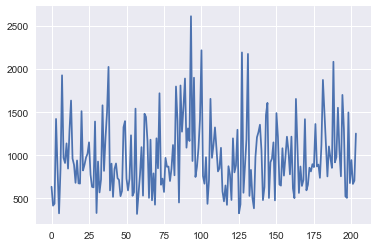

In [33]:
plot(rmsesss)